Shape of X: torch.Size([150, 4])
Shape of transformed X: torch.Size([150, 2])


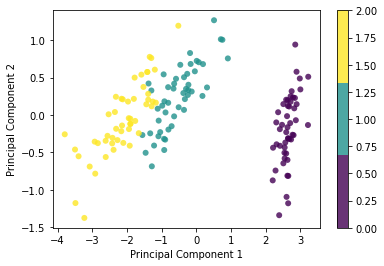

In [8]:
import torch


class PCA_OnTorch:
    def __init__(self):
        self.n_components = None
        self.components = None
        self.mean = None

    def fit(self, X, Variance):
        # eigenvalues, eigenvectors
        pca_object = self.PCA_svd(X, variance=Variance)
        eigenvalues = pca_object['explained_variance']
        eigenvectors = pca_object['components']
        self.n_components = pca_object['k']
        self.mean = pca_object['center']

        # store first n eigenvectors
        self.components = eigenvectors

    def transform(self, X):
        # project data
        X = X - self.mean
        self.zresult = torch.matmul(X, self.components.T) 
        return self.zresult
    
    def original(self):
        xapprox  = torch.matmul(self.zresult, self.components) + self.mean
        return xapprox
    
    def get_optimal_k(self, s,v,n,components, explained_variance, explained_ratio, variance=0.99):
        cumu=0
        k=0
        for i,j in enumerate(explained_ratio):
            cumu+=j
            if cumu > variance:
                k=i
                break
        idxs = torch.argsort(explained_variance, descending=True)
        eigenvalues = explained_variance[idxs]
        eigenvectors = components[idxs]
        components  = eigenvectors[:k]
        explained_variance = eigenvalues[:k]
        return k, components, explained_variance
    
    def PCA_svd(self, X, center=True, variance=0.99):
        (n, k) = X.shape[-2:]
        center_data = X.mean(dim=(-2,), keepdim=True) if center else X
        mean_data = X - center_data
        u, s, v = torch.pca_lowrank(mean_data, q=None, center=False, niter=2) 
        components  = v[:k].t()
        explained_variance = torch.mul(s[:k], s[:k])/(n-1)
        explained_ratio = [eigen / torch.sum(explained_variance) for eigen in explained_variance]
        k, components, explained_variance = self.get_optimal_k(s,v,n,components, explained_variance, explained_ratio, variance=variance)
        return {'k':k, 'components':components,
                'explained_variance':explained_variance,
                'explained_ratio':explained_ratio,
                'center':center_data}
    

# Testing
if __name__ == "__main__":
    # Imports
    import matplotlib.pyplot as plt
    from sklearn import datasets

    # data = datasets.load_digits()
    data = datasets.load_iris()
    X = torch.tensor(data.data)
    y = data.target

    # Project the data onto the 2 primary principal components
    pca = PCA_OnTorch()
    pca.fit(X, Variance=0.99)
    X_projected = pca.transform(X)
    X_original = pca.original()

    print("Shape of X:", X.shape)
    print("Shape of transformed X:", X_projected.shape)

    x1 = X_projected[:, 0]
    x2 = X_projected[:, 1]

    plt.scatter(
        x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3)
    )

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar()
    plt.show()